In [1]:
import track
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

In [2]:
RESULTS_DIR = '/Users/noah/Dev/SGLD/experiment_results'
proj = track.Project(RESULTS_DIR)
experiments = proj.ids.groupby('mode')

def load_experiment(mode):
    assert mode != 'tsne', 'use load_tsne for this one'
    for m, group in experiments:
        if m != mode:
            continue
        last_exp = group['end_time'].idxmax()
        trial_id = proj.ids['trial_id'].iloc[[last_exp]]
        res = proj.results(trial_id)
        return res

# Entropy and OOD Plotting

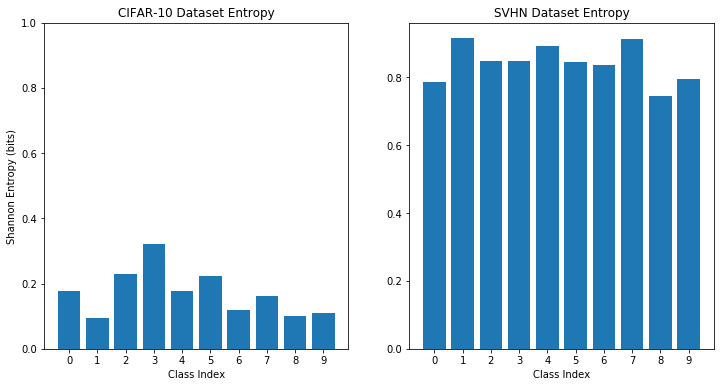

In [72]:
entropy_df = load_experiment('entropy')


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.ylim(0,1)
plt.xticks(list(range(0, 10)))



plt.bar(entropy_df['cifar_class_id'], entropy_df['entropy'])
plt.title("CIFAR-10 Dataset Entropy")
plt.ylabel("Shannon Entropy (bits)")
plt.xlabel("Class Index")

plt.subplot(1,2,2)
plt.bar(ood_df['svnh_class_id'], ood_df['entropy'])
plt.title("SVHN Dataset Entropy")
plt.xlabel("Class Index")
plt.xticks(list(range(0, 10)))




plt.show()



## I SHOULD ALSO PLOT ACCURACY

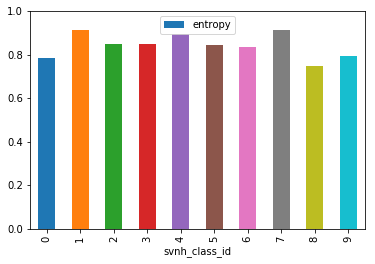

# Ensemble Size

In [30]:
# moving average (for smooth curves)
def ma(a, n):
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    s = n - 1
    ret[s:] /= n
    ret[:s] /= np.arange(s) + 1
    return ret

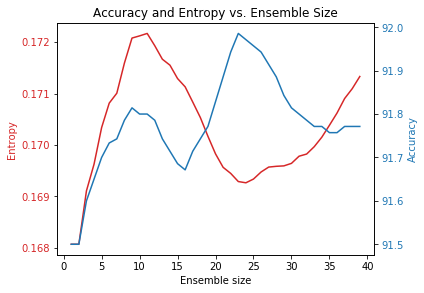

In [33]:
ensemble_size_df = load_experiment('ensemble_size')

xs = ensemble_size_df['ensemble_size']
accs = ensemble_size_df['ensemble_full_acc']
entropies = ensemble_size_df['ensemble_full_entropy']

fig, ax1 = plt.subplots()

color = 'tab:red'
smoothness = 7
ax1.set_xlabel('Ensemble size')
ax1.set_ylabel('Entropy', color=color)
ax1.plot(xs, ma(entropies.values, smoothness), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(xs, ma(accs.values, smoothness), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Accuracy and Entropy vs. Ensemble Size")
plt.show()

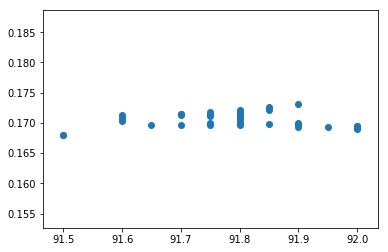

In [7]:
plt.scatter(ma(accs.values, 2), ma(entropies.values, 2))

# t-SNE

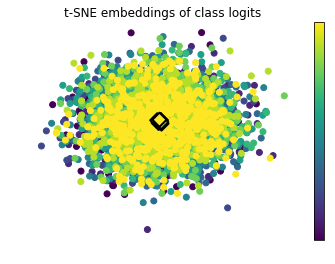

In [68]:
TSNE_DIR = '/Users/noah/Dev/SGLD/tsne_results'
np_load = lambda x: pickle.load(open(os.path.join(TSNE_DIR, x), 'rb'))
embedding = np_load('embedding.npy')        # all 2-d embedding vecs for all models
embed_labels = np_load('embed_labels.npy')  # model index for each embedding
model_means = np_load('model_means.npy')    # centroids of embedding for each model
model_labels = np_load('model_labels.npy')  # model indices for the centroids

f = plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=embed_labels * 1.0 / embed_labels.max())
plt.scatter(model_means[:, 0], model_means[:, 1], c=model_labels, s=100,
            linewidth=2, edgecolors='black', marker='D')
plt.axis('off')
plt.title("t-SNE embeddings of class logits")

plt.colorbar(orientation='vertical', ticks=[])
#cbar.ax.set_yticklabels(['Low', 'High'])
#plt.colorbar()
plt.show()